Goal: Use OOP to make in depth player analysis code reusable

In [28]:
class Player:
    def __init__(self, player, team):
        self.player = player
        self.team = team
#         self.df = setup_df()

    def setup_df(self):
        '''Set up the player's results dataframe'''
        player=self.player
        team=self.team
        import pickle
        import pandas as pd
        path = '//DREW/Users/andrew/Desktop/mosconi/'
        dframe = pickle.load(open(path+'pkl/allyears_clean_locs','rb'))
        dframe['Europe_lost'] = ~ dframe['Europe_won']
        if 'a' in team.lower():
            df = dframe[dframe['American_player'].str.contains(player)]
            df = df[['Format', 'European_player', 'European_score', 'American_score',
               'American_player', 'Europe_lost','Europe_won']]
            df.columns = ['Format', 'European_player', 'European_score', 'American_score',
               'American_player', 'America_won', 'America_lost']
        else:
            df = dframe[dframe['European_player'].str.contains(player)]
        return(df,dframe)
    
    def stats(self,df):
        team=self.team
        try:
            if 'a' in team.lower():
                win = df['America_won'].sum()
                loss = df['America_lost'].sum()
            else:
                win = df['Europe_won'].sum()
                loss = df['Europe_lost'].sum()
            mp= win+loss
            wl = 'Win-loss: {}-{}'.format(win,loss)
            pct = round(win/(win+loss)*100,0)
            return('Matches Played: {}'.format(mp),wl,'Pct: {}'.format(pct))
        except:
            return('No matches to display')

    def overall_stats(self,df):
        team=self.team
        sing = df[df['Format']=='Singles']
        dub = df[df['Format']=='Doubles']
        teams = df[df['Format']=='Teams']
        triples = df[df['Format']=='Triples'] 
        outstr='Overall: {}\nSingles: {}\nDoubles: {}\nTeams:   {}\nTriples: {}\n'.format(self.stats(df), self.stats(sing), self.stats(dub), self.stats(teams), self.stats(triples))
        print(outstr)
        return(sing,dub,teams,triples)
    
    def partners(self,dub):
        player=self.player
        if 'America_won' in dub:
            dub = dub[['European_player','American_player','America_won','America_lost']].copy()
            dub['Partner']=dub['American_player'].str.replace(player,'')
            dub['Partner']=dub['Partner'].str.replace('&','')
            dub['Partner']=dub['Partner'].str.strip()
            d = dub.groupby('Partner').sum().sort_values(['America_won','America_lost'],ascending=False)
            return d    
        else:
            dub = dub[['European_player','American_player','Europe_won','Europe_lost']]
            dub['Partner']=dub['European_player'].str.replace(player,'')
            dub['Partner']=dub['Partner'].str.replace('&','')
            dub['Partner']=dub['Partner'].str.strip()
            return dub.groupby('Partner').sum().sort_values(['Europe_won','Europe_lost'],ascending=False)

    def opponents(self,sing):
        if 'America_won' in sing:
            return sing.groupby('European_player').sum().sort_values('America_won',ascending = False)
        else:
            return sing.groupby('American_player').sum().sort_values('Europe_won',ascending = False)
        
    def yearly_plot(self,df):
        import numpy as np
        import matplotlib.pyplot as plt
        
        lst =df.index.values.tolist() 
        years = set([])
        
        for item in lst:
            years.add(item[0])
        years=list(years)

        yearly=[]
        for year in years:
            if 'America_won' in df:
                w = df.loc[year]['America_won'].sum()
                l = df.loc[year]['America_lost'].sum()
            else:
                w = df.loc[year]['Europe_won'].sum()
                l = df.loc[year]['Europe_lost'].sum()
            yearly.append((w,l))

        yr= {}
        for k,v in zip(years,yearly):
            yr[k]=v

        win=[]
        loss=[]
        pct=[]
        for w,l in yearly:
            win.append(w)
            loss.append(l)
            p=round((w*100/(w+l)),0)
            pct.append(p)

        # from IPython.core.interactiveshell import InteractiveShell
        # InteractiveShell.ast_node_interactivity = "last_expr"

        fig = plt.figure(figsize=(14, 8))
        ax = fig.add_subplot(111)

        x= years
        y= pct

        ind = range(len(years))  

        ax.plot(y,linestyle='-',marker='.',markersize=12)
        ax.axhline(50, color='r',linestyle='--')

        ax.set_ylabel('Percentage of Games Won');
        ax.set_title('Yearly Performance Average');
        ax.set_xticks(ind);
        ax.set_xticklabels(x,rotation=30);

        for i in range(len(years)):
            plt.annotate( '{}-{}'.format(yearly[i][0],yearly[i][1]), (ind[i]+.2,y[i]) )
        plt.show()
        return years
    
    def wincount(self,dframe,years):
        team=self.team
        l=0
        w=0
        tie=0
        print('Team win-loss record by year:\n')
        for year in years:
            f,t = dframe.loc[year]['Europe_won'].value_counts(sort=False)
            print('{}: {}-{}'.format(year,f,t))
            if f>t:
                l+=1
            elif f<t:
                w+=1 
            else:
                tie+=1
        if 'a' in team:
            l,w = w,l
        print('\n')
        print( 'Total team win-loss-tie: {}-{}-{}\n'.format(w,l,tie)  )
        
    def location(self,df,years):
        team=self.team
        import pickle
        path = '//DREW/Users/andrew/Desktop/mosconi/'
        locs = pickle.load(open(path+'pkl/dloc','rb'))

        hm = []
        aw = []

        for year in years:
            if 'USA' in locs[year]:
                if 'a' in team.lower():
                    hm.append(year)
                else:
                    aw.append(year)
            else:
                if 'a' in team.lower():
                    aw.append(year)
                else:
                    hm.append(year)
        away = df.loc[aw]
        home = df.loc[hm]

        print( '\t Played home {} times, away {} times \n Home Games: {} \n Away Games: {}\n'.format(len(hm),len(aw),self.stats(home),self.stats(away)))
        return(home,away)

    def location_split(self,home,away):
        team = self.team
        hsing = self.stats(home[home['Format']=='Singles'])
        hdub = self.stats(home[home['Format']=='Doubles'])
        asing = self.stats(away[away['Format']=='Singles'])
        adub = self.stats(away[away['Format']=='Doubles'])

        print(' Home Singles: {} \n Home Doubles: {} \n Away Singles: {} \n Away Doubles: {}\n'.format(hsing,hdub,asing,adub))

    def call_em(self):
        player=self.player
        team=self.team
        df,dframe = self.setup_df()
        sing,dub,teams,triples = self.overall_stats(df)
        print('-----Win-loss breakdown by partner----- \n')
        print(self.partners(dub))
        print('\n')
        print('-----Win-loss breakdown by opponent (singles)----- \n')
        print(self.opponents(sing))
        years = self.yearly_plot(df)
        self.wincount(dframe,years)
        home,away = self.location(df,years)
        self.location_split(home,away)
        return

In [29]:
svb=Player('Shane Van Boening','America')

In [30]:
svb.player

'Shane Van Boening'

In [31]:
svb.team

'America'

In [32]:
df,dframe=svb.setup_df()

In [33]:
import pandas as pd

In [34]:
pd.DataFrame()

""


In [35]:
df.head()

Format  \
Year Location               Match            
2007 Las Vegas, Nevada, USA 0        Teams   
                            2      Singles   
                            5      Doubles   
                            8      Singles   
                            12     Doubles   

                                                                     European_player  \
Year Location               Match                                                      
2007 Las Vegas, Nevada, USA 0      Daryl Peach, Tony Drago, Konstantin Stepanov, ...   
                            2                                            Daryl Peach   
                            5                               Daryl Peach Ralf Souquet   
                            8                                             Tony Drago   
                            12                       Konstantin Stepanov Daryl Peach   

                                  European_score American_score  \
Year Location               Match                                 
2007 Las Vegas, Nevada, USA 0                  4              6   
                            2                  2              6   
                            5                  6              0   
                            8                  6              2   
                            12                 3              6   

                                                                     American_player  \
Year Location               Match                                                      
2007 Las Vegas, Nevada, USA 0      Corey Deuel, Earl Strickland, Shane Van Boenin...   
                            2                                      Shane Van Boening   
                            5                      Earl Strickland Shane Van Boening   
                            8                                      Shane Van Boening   
                            12                       Johnny Archer Shane Van Boening   

                                  America_won America_lost  
Year Location               Match                           
2007 Las Vegas, Nevada, USA 0            True        False  
                            2            True        False  
                            5           False         True  
                            8           False         True  
                            12           True        False

In [36]:
svb.stats(df)

('Matches Played: 60', 'Win-loss: 25-35', 'Pct: 42.0')

In [37]:
sing,dub,teams,triples= svb.overall_stats(df)

Overall: ('Matches Played: 60', 'Win-loss: 25-35', 'Pct: 42.0')
Singles: ('Matches Played: 25', 'Win-loss: 10-15', 'Pct: 40.0')
Doubles: ('Matches Played: 25', 'Win-loss: 11-14', 'Pct: 44.0')
Teams:   ('Matches Played: 10', 'Win-loss: 4-6', 'Pct: 40.0')
Triples: No matches to display



In [38]:
svb.partners(dub)

,America_won,America_lost
Partner,,
Johnny Archer,4.0,1.0
Dennis Hatch,2.0,0.0
Rodney Morris,1.0,4.0
Corey Deuel,1.0,2.0
Mike Dechaine,1.0,2.0
Earl Strickland,1.0,1.0
Skyler Woodward,1.0,1.0
John Schmidt,0.0,1.0
Justin Bergman,0.0,1.0


In [39]:
svb.opponents(sing)

,America_won,America_lost
European_player,,
Nick van den Berg,3.0,0.0
Darren Appleton,1.0,6.0
Daryl Peach,1.0,0.0
Karl Boyes,1.0,0.0
Konstantin Stepanov,1.0,0.0
Mika Immonen,1.0,2.0
Ralf Souquet,1.0,2.0
Tony Drago,1.0,1.0
Chris Melling,0.0,1.0


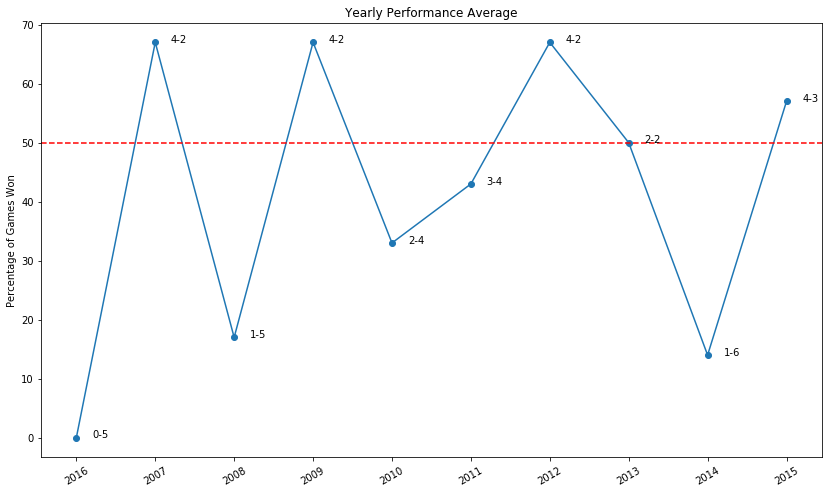

In [40]:
years=svb.yearly_plot(df)

In [41]:
svb.wincount(dframe,years)

Team win-loss record by year:

2016: 3-11
2007: 8-11
2008: 5-11
2009: 11-7
2010: 8-11
2011: 7-11
2012: 9-11
2013: 2-11
2014: 5-11
2015: 7-11


Total team win-loss-tie: 1-9-0



In [42]:
home,away = svb.location(df,years)

	 Played home 5 times, away 5 times 
 Home Games: ('Matches Played: 30', 'Win-loss: 17-13', 'Pct: 57.0') 
 Away Games: ('Matches Played: 30', 'Win-loss: 8-22', 'Pct: 27.0')



In [43]:
svb.location_split(home,away)

 Home Singles: ('Matches Played: 13', 'Win-loss: 7-6', 'Pct: 54.0') 
 Home Doubles: ('Matches Played: 12', 'Win-loss: 7-5', 'Pct: 58.0') 
 Away Singles: ('Matches Played: 12', 'Win-loss: 3-9', 'Pct: 25.0') 
 Away Doubles: ('Matches Played: 13', 'Win-loss: 4-9', 'Pct: 31.0')



Overall: ('Matches Played: 60', 'Win-loss: 25-35', 'Pct: 42.0')
Singles: ('Matches Played: 25', 'Win-loss: 10-15', 'Pct: 40.0')
Doubles: ('Matches Played: 25', 'Win-loss: 11-14', 'Pct: 44.0')
Teams:   ('Matches Played: 10', 'Win-loss: 4-6', 'Pct: 40.0')
Triples: No matches to display

-----Win-loss breakdown by partner----- 

                 America_won  America_lost
Partner                                   
Johnny Archer            4.0           1.0
Dennis Hatch             2.0           0.0
Rodney Morris            1.0           4.0
Corey Deuel              1.0           2.0
Mike Dechaine            1.0           2.0
Earl Strickland          1.0           1.0
Skyler Woodward          1.0           1.0
John Schmidt             0.0           1.0
Justin Bergman           0.0           1.0
Óscar Domínguez          0.0           1.0


-----Win-loss breakdown by opponent (singles)----- 

                     America_won  America_lost
European_player                               
Nick va

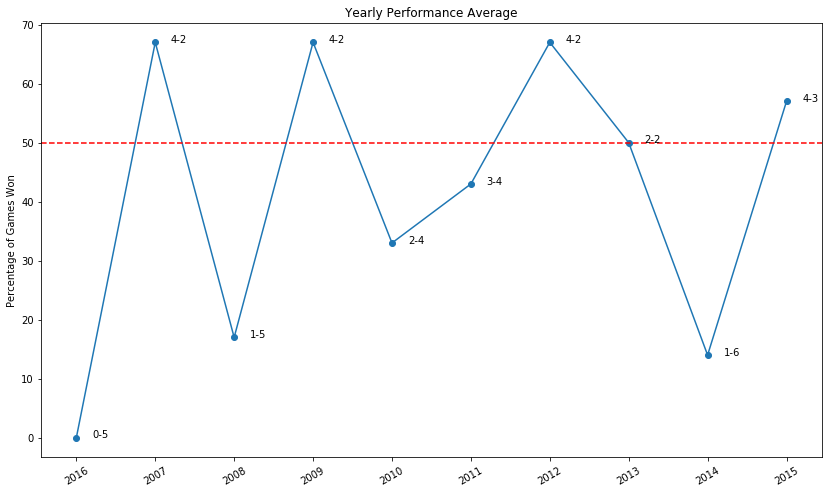

Team win-loss record by year:

2016: 3-11
2007: 8-11
2008: 5-11
2009: 11-7
2010: 8-11
2011: 7-11
2012: 9-11
2013: 2-11
2014: 5-11
2015: 7-11


Total team win-loss-tie: 1-9-0

	 Played home 5 times, away 5 times 
 Home Games: ('Matches Played: 30', 'Win-loss: 17-13', 'Pct: 57.0') 
 Away Games: ('Matches Played: 30', 'Win-loss: 8-22', 'Pct: 27.0')

 Home Singles: ('Matches Played: 13', 'Win-loss: 7-6', 'Pct: 54.0') 
 Home Doubles: ('Matches Played: 12', 'Win-loss: 7-5', 'Pct: 58.0') 
 Away Singles: ('Matches Played: 12', 'Win-loss: 3-9', 'Pct: 25.0') 
 Away Doubles: ('Matches Played: 13', 'Win-loss: 4-9', 'Pct: 31.0')



In [44]:
svb.call_em()

In [45]:
earl=Player('Earl Strickland','America')

Overall: ('Matches Played: 69', 'Win-loss: 43-26', 'Pct: 62.0')
Singles: ('Matches Played: 26', 'Win-loss: 14-12', 'Pct: 54.0')
Doubles: ('Matches Played: 36', 'Win-loss: 24-12', 'Pct: 67.0')
Teams:   ('Matches Played: 5', 'Win-loss: 3-2', 'Pct: 60.0')
Triples: ('Matches Played: 1', 'Win-loss: 1-0', 'Pct: 100.0')

-----Win-loss breakdown by partner----- 

                   America_won  America_lost
Partner                                     
Rodney Morris              7.0           4.0
Jeremy Jones               5.0           2.0
James Rempe                4.0           3.0
Corey Deuel                2.0           1.0
Johnny Archer              2.0           0.0
Shane Van Boening          1.0           1.0
C.J. Wiley                 1.0           0.0
Kim Davenport              1.0           0.0
Tony Robles                1.0           0.0
Dennis Hatch               0.0           1.0


-----Win-loss breakdown by opponent (singles)----- 

                    America_won  America_lost
E

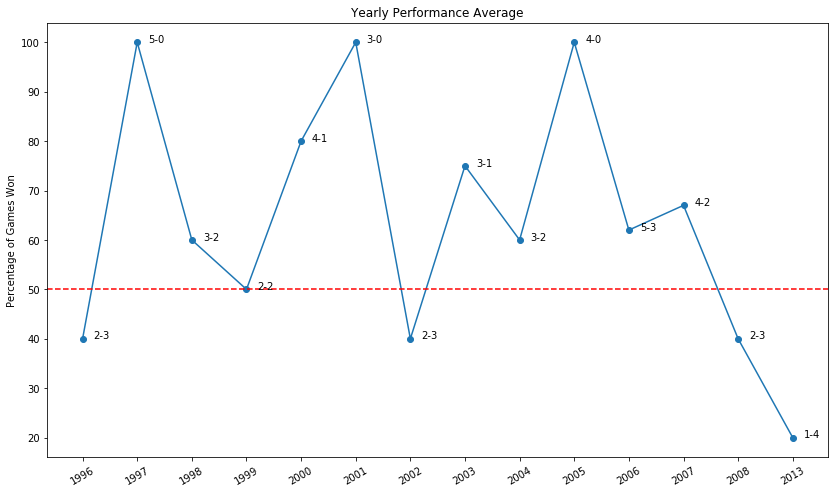

Team win-loss record by year:

1996: 15-13
1997: 13-8
1998: 13-9
1999: 12-7
2000: 12-9
2001: 12-1
2002: 9-12
2003: 11-9
2004: 12-9
2005: 11-6
2006: 12-12
2007: 8-11
2008: 5-11
2013: 2-11


Total team win-loss-tie: 9-4-1

	 Played home 4 times, away 10 times 
 Home Games: ('Matches Played: 19', 'Win-loss: 12-7', 'Pct: 63.0') 
 Away Games: ('Matches Played: 50', 'Win-loss: 31-19', 'Pct: 62.0')

 Home Singles: ('Matches Played: 6', 'Win-loss: 3-3', 'Pct: 50.0') 
 Home Doubles: ('Matches Played: 11', 'Win-loss: 8-3', 'Pct: 73.0') 
 Away Singles: ('Matches Played: 20', 'Win-loss: 11-9', 'Pct: 55.0') 
 Away Doubles: ('Matches Played: 25', 'Win-loss: 16-9', 'Pct: 64.0')



In [46]:
earl.call_em()